Машины опорных векторов (сокращенно SVM) — это контролируемые алгоритмы машинного обучения, которые используются для целей классификации и регрессии. В этом задании вам необходимо обучить Support Vector Machines для классификации пульсаров. 


**1. Прочитайте данные, сделайте беглый EDA:
- посмотрите на кол-во данных, названия столбцов, нет ли в них ошибок
- переименуйте для более удобной работы
- есть ли пропущенные значения.
- Посмотрите нет ли дисбаланса классов по таргету? Сделайте саммари по признакам.
- Отобразите боксплоты признаков, чтобы оценить выбросы в данных.
- Постройте гистограммы признаков, чтобы взглянуть на распределение данных.**

In [82]:
!pip install numpy pandas matplotlib seaborn

In [83]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = 'pulsar_data_train.csv'

df = pd.read_csv(data)

In [84]:
print(df.shape)
df.head()

(12528, 9)


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [85]:
df.isnull().sum() # проверка пустых значений в данных

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64

In [86]:
for col_name in df.columns:
    if col_name in [" Excess kurtosis of the integrated profile", " Standard deviation of the DM-SNR curve", " Skewness of the DM-SNR curve"]:
        print(f"{col_name} - {(df[col_name].isnull().sum() / df[col_name].count() * 100).round(1)}% пропусков ({df[col_name].isnull().sum()} / {df[col_name].count()}) ")

 Excess kurtosis of the integrated profile - 16.1% пропусков (1735 / 10793) 
 Standard deviation of the DM-SNR curve - 10.4% пропусков (1178 / 11350) 
 Skewness of the DM-SNR curve - 5.3% пропусков (625 / 11903) 


In [87]:
df.select_dtypes(include=[np.number]).columns.tolist() # числовые значения

[' Mean of the integrated profile',
 ' Standard deviation of the integrated profile',
 ' Excess kurtosis of the integrated profile',
 ' Skewness of the integrated profile',
 ' Mean of the DM-SNR curve',
 ' Standard deviation of the DM-SNR curve',
 ' Excess kurtosis of the DM-SNR curve',
 ' Skewness of the DM-SNR curve',
 'target_class']

In [88]:
df.select_dtypes(include=['object']).columns.tolist() # категориальные

[]

In [89]:
# ip_* - integrated profile признаки
# dm_snr_* - DM-SNR curve признаки
# is_pulsar - бинарная целевая переменная

column_names = {
    " Mean of the integrated profile": "ip_mean",
    " Standard deviation of the integrated profile": "ip_std",
    " Excess kurtosis of the integrated profile": "ip_kurt",
    " Skewness of the integrated profile": "ip_skew",
    " Mean of the DM-SNR curve": "dm_snr_mean",
    " Standard deviation of the DM-SNR curve": "dm_snr_std",
    " Excess kurtosis of the DM-SNR curve": "dm_snr_kurt",
    " Skewness of the DM-SNR curve": "dm_snr_skew",
    "target_class": "is_pulsar"
}
df = df.rename(columns=column_names)
df.head()

,ip_mean,ip_std,ip_kurt,ip_skew,dm_snr_mean,dm_snr_std,dm_snr_kurt,dm_snr_skew,is_pulsar
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [90]:
df.describe()

,ip_mean,ip_std,ip_kurt,ip_skew,dm_snr_mean,dm_snr_std,dm_snr_kurt,dm_snr_skew,is_pulsar
count,12528.000000,12528.000000,10793.000000,12528.000000,12528.000000,11350.000000,12528.000000,11903.000000,12528.000000
mean,111.041841,46.521437,0.478548,1.778431,12.674758,26.351318,8.333489,105.525779,0.092034
std,25.672828,6.801077,1.064708,6.208450,29.613230,19.610842,4.535783,107.399585,0.289085
min,5.812500,24.772042,-1.738021,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.871094,42.362222,0.024652,-0.188142,1.910535,14.404353,5.803063,35.199899,0.000000
50%,115.183594,46.931022,0.223678,0.203317,2.792642,18.412402,8.451097,83.126301,0.000000
75%,127.109375,50.979103,0.473125,0.932374,5.413253,28.337418,10.727927,139.997850,0.000000
max,189.734375,91.808628,8.069522,68.101622,222.421405,110.642211,34.539844,1191.000837,1.000000


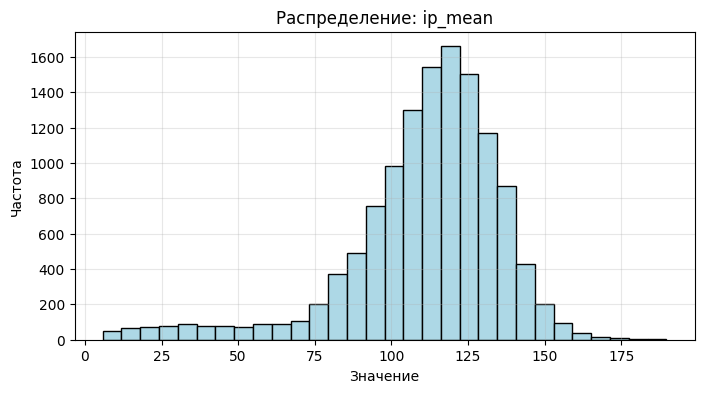

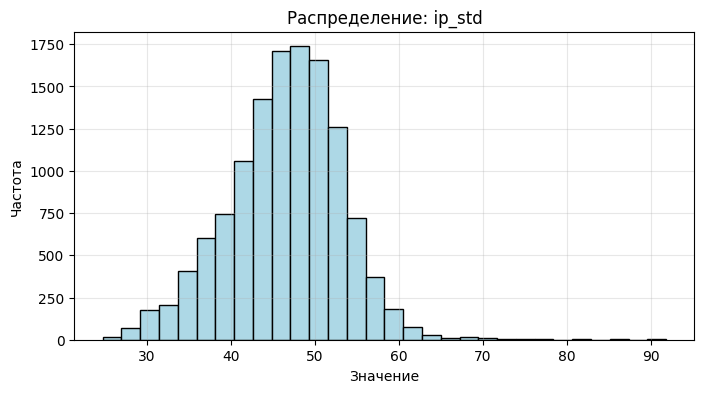

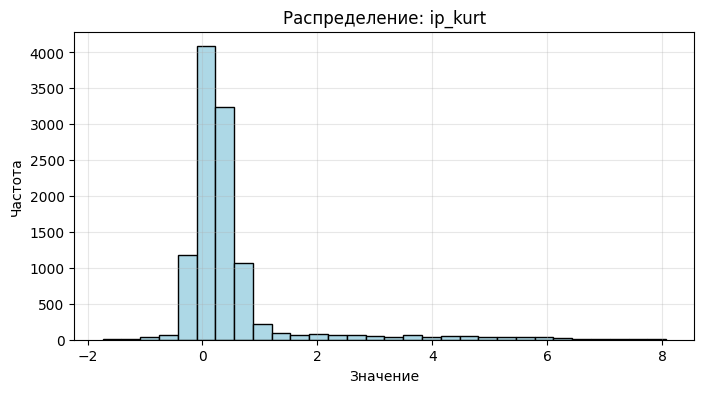

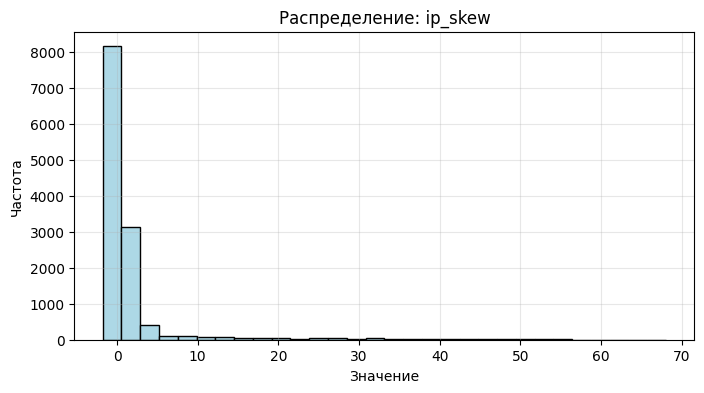

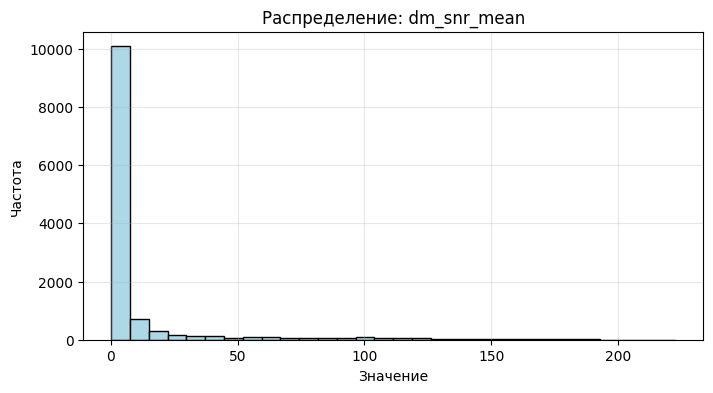

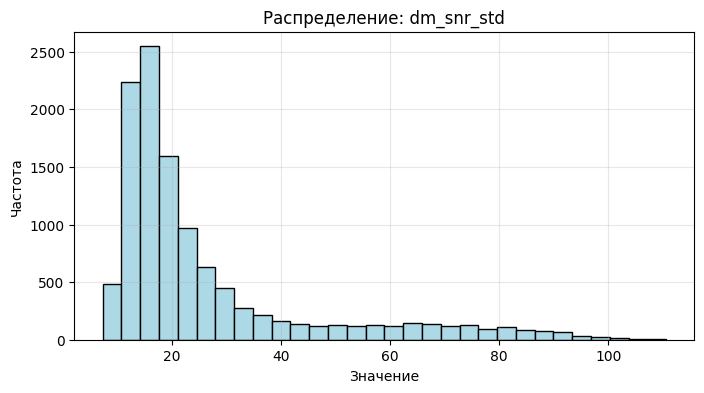

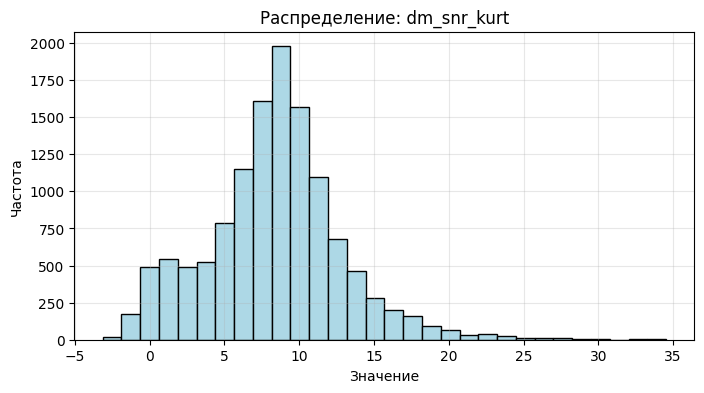

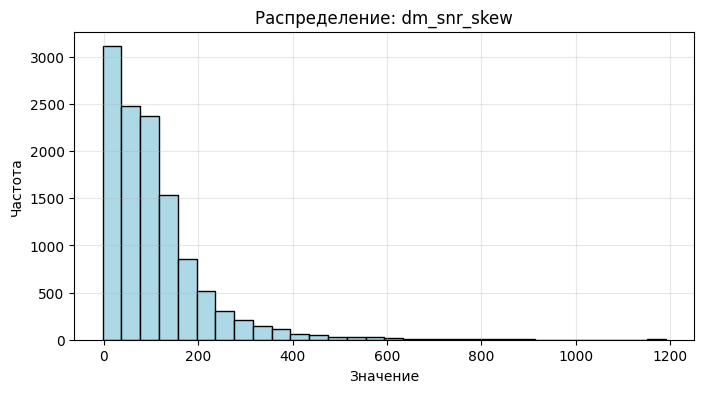

In [91]:
# Посмотреть распределение признаков, особенно уделить вниманием вот этим, с пустыми данными: 
# Excess kurtosis of the integrated profile       1735
# Standard deviation of the DM-SNR curve          1178
# Skewness of the DM-SNR curve                     625


for feature in [
    'ip_mean',
    'ip_std', 
    'ip_kurt',
    'ip_skew',
    'dm_snr_mean',
    'dm_snr_std',
    'dm_snr_kurt', 
    'dm_snr_skew'
]:
    plt.figure(figsize=(8, 4))
    plt.hist(df[feature], bins=30, color='lightblue', edgecolor='black')
    plt.title(f'Распределение: {feature}')
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.grid(True, alpha=0.3)
    plt.show()

In [92]:
# Анализ дисбаланса классов по таргету
target_counts = df['is_pulsar'].value_counts()
ratio = target_counts[0] / target_counts[1]

print(f"Класс 0 (не пульсар): {target_counts[0]:,} ({target_counts[0]/len(df)*100:.1f}%)")
print(f"Класс 1 (пульсар): {target_counts[1]:,} ({target_counts[1]/len(df)*100:.1f}%)")

print(f"ratio: {ratio.round(2)}")

Класс 0 (не пульсар): 11,375 (90.8%)
Класс 1 (пульсар): 1,153 (9.2%)
ratio: 9.87


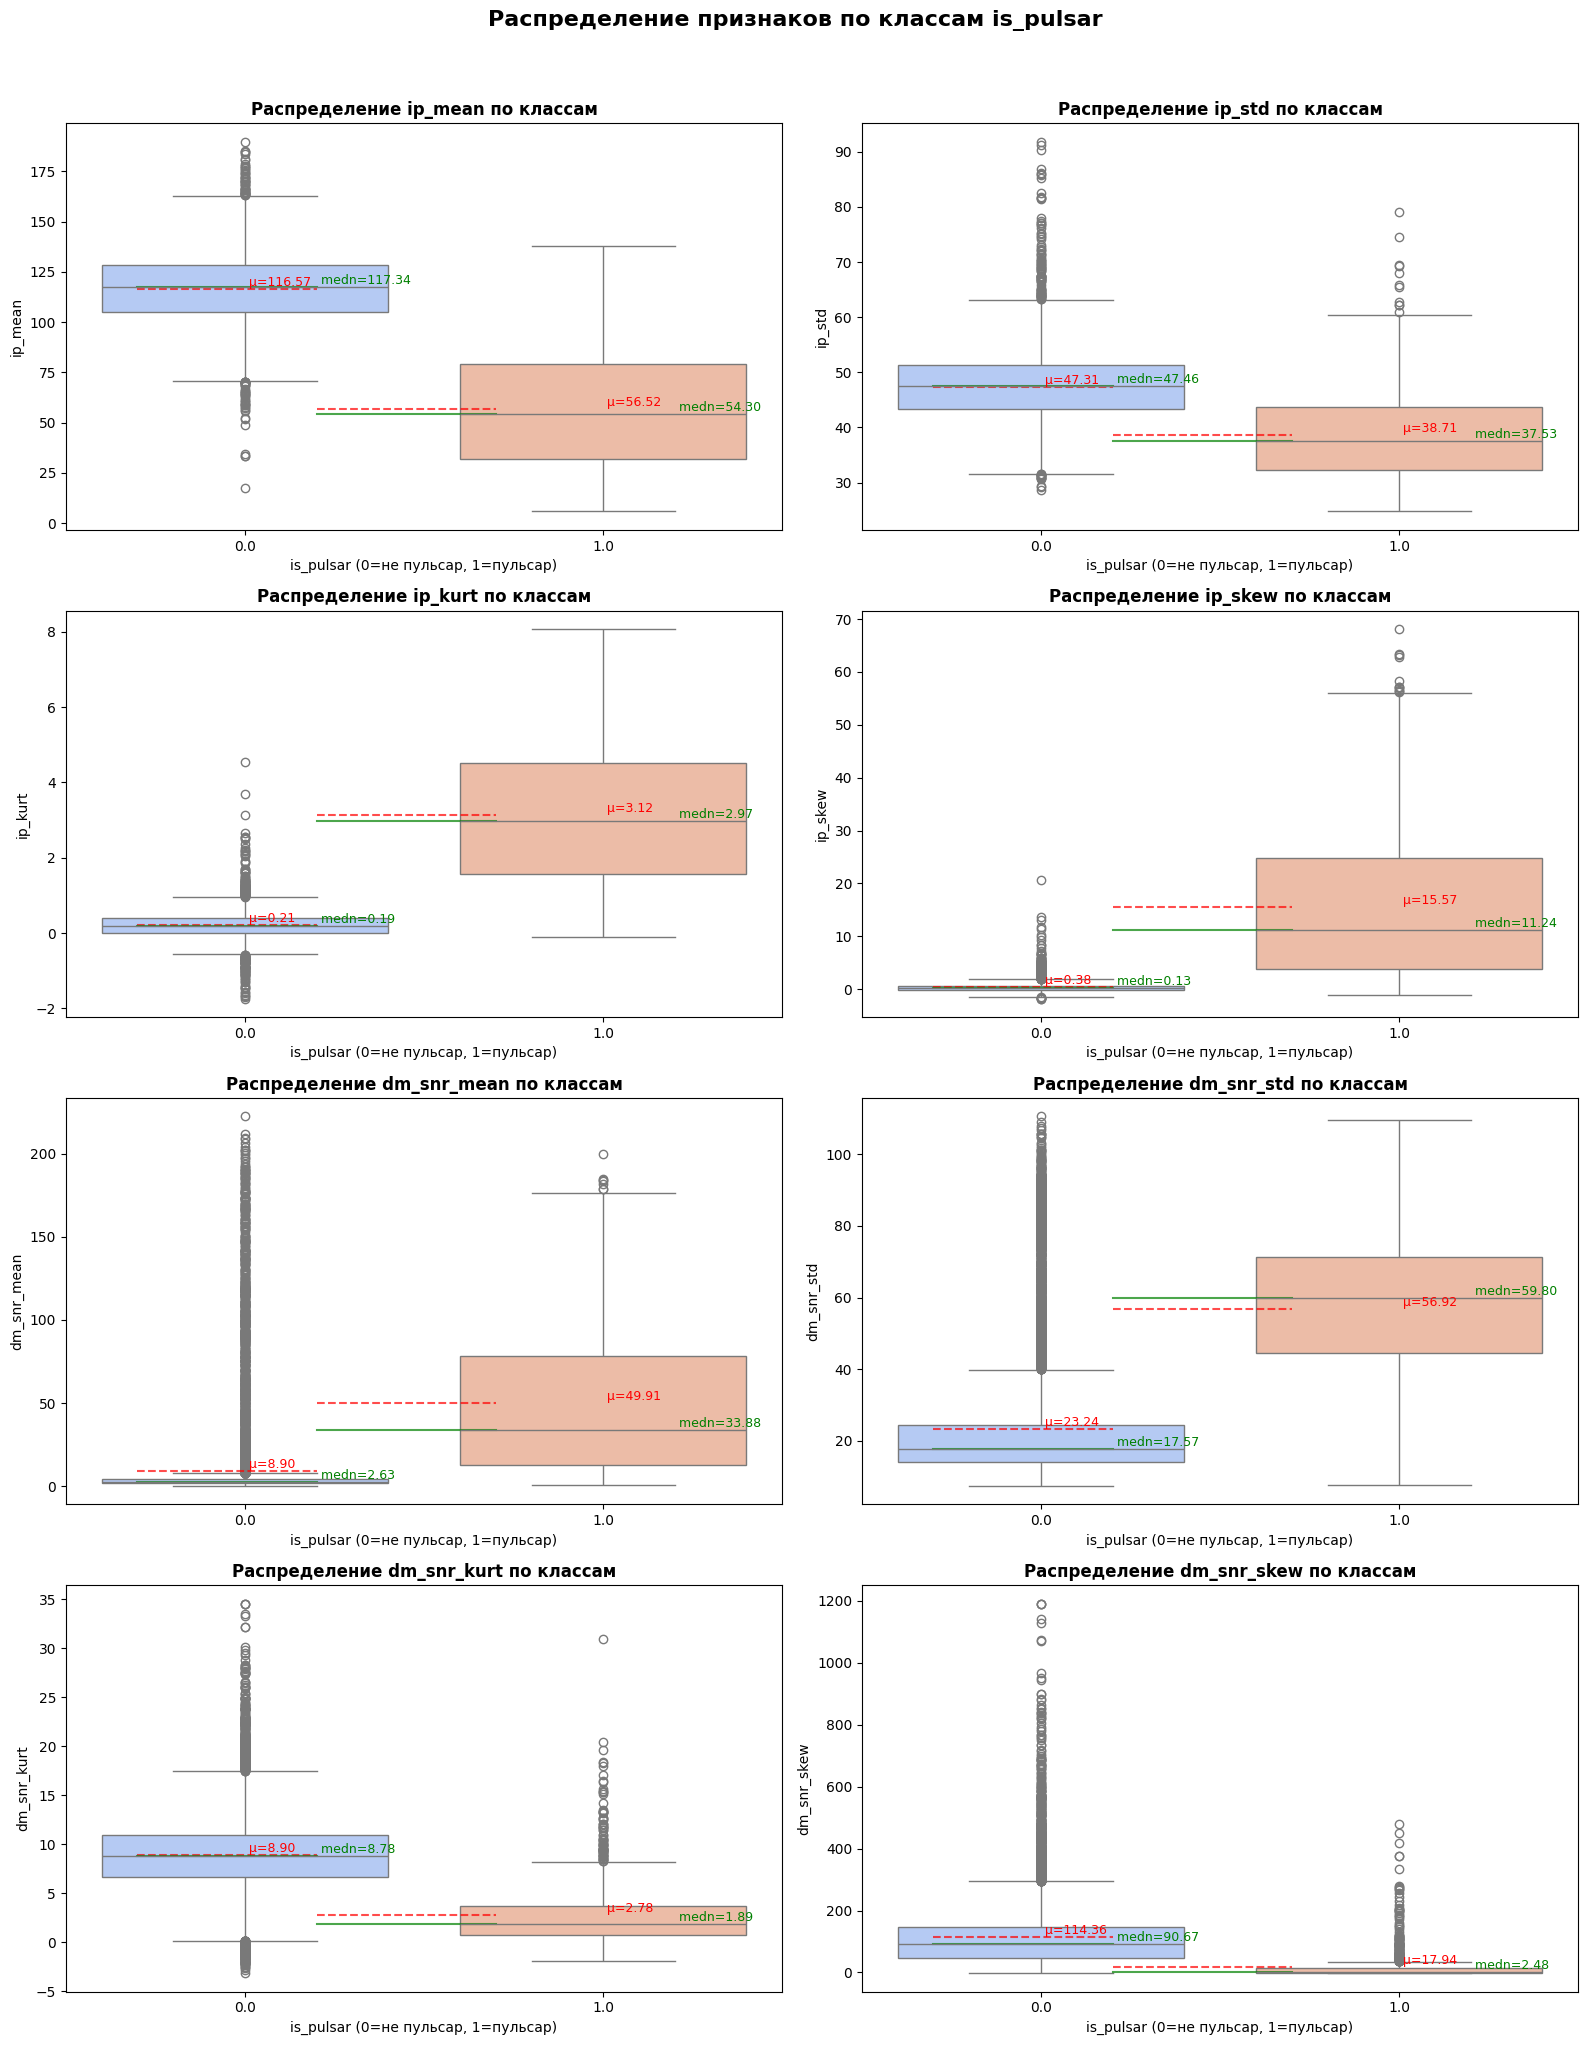

In [93]:
# Признаки для анализа (без таргета)
features = ['ip_mean', 'ip_std', 'ip_kurt', 'ip_skew', 
            'dm_snr_mean', 'dm_snr_std', 'dm_snr_kurt', 'dm_snr_skew']

fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    
    # Boxplot для каждого признака по классам is_pulsar
    sns.boxplot(data=df, x='is_pulsar', y=feature, ax=ax, 
                palette='coolwarm', hue='is_pulsar', legend=False)
    
    ax.set_title(f'Распределение {feature} по классам', fontsize=12, fontweight='bold')
    ax.set_xlabel('is_pulsar (0=не пульсар, 1=пульсар)')
    ax.set_ylabel(feature)
    
    # среднее
    means = df.groupby('is_pulsar')[feature].mean()
    for j, mean_val in enumerate(means):
        ax.axhline(mean_val, xmin=0.25*j+0.1, xmax=0.25*j+0.35, 
                  color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        ax.text(j, mean_val, f' μ={mean_val:.2f}', 
                verticalalignment='bottom', fontsize=9, color='red')

    # медиана
    medians = df.groupby('is_pulsar')[feature].median()
    for j, median_val in enumerate(medians):
        ax.axhline(median_val, xmin=0.25*j+0.1, xmax=0.25*j+0.35, 
                  color='green', linestyle='solid', linewidth=1.5, alpha=0.7)
        ax.text(j+0.2, median_val, f' medn={median_val:.2f}', 
                verticalalignment='bottom', fontsize=9, color='green')

plt.suptitle('Распределение признаков по классам is_pulsar', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**2. Определите матрицу признаков и переменную таргета. Разделите трейновый набор трейн и тест с помощью train_test_split. Зафиксируйте размер тестовой выборки 0.2, а рэндом стэйт равный 0.** 

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_filled = df.fillna(df.median()) # заполним пропуски медианой

X = df_filled.drop(['is_pulsar'], axis=1)
y = df_filled['is_pulsar']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

X_train.shape, X_test.shape

((10022, 8), (2506, 8))

**3. Используя StandartScaler отмасштабируйте матрицу признаков трейн и тест.**

In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**4. Обучите SVM Classifier на данных используя GridSearchCV: Попробуйте разные значения С, типа ядер, а так же значение гамма для rbf ядра. Подберите правильную метрику для оценки качества алгоритма. Убедитесь, что значения на тестровой и трейновой выборке сопоставимы и модель не переобучилась.**

In [96]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf', 
    class_weight='balanced', 
    probability=True, 
    random_state=42
)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 'scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_svm = GridSearchCV(
    svm_model,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train_scaled, y_train)

%time grid_svm.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 4.07 s, sys: 364 ms, total: 4.44 s
Wall time: 6min 19s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC(class_wei...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.1, 1, ...], 'gamma': [0.0001, 0.001, ...], 'kernel': ['linear', 'rbf', ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidat

**5. Постройте confusion_matrix и classification report.**

In [97]:
print(grid_svm.best_params_)

model = grid_svm.best_estimator_

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion matrix: \n{cm}")

print(classification_report(y_test, y_pred, target_names=['Не пульсар', 'Пульсар']))

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Confusion matrix: 
[[2218   57]
 [  29  202]]
              precision    recall  f1-score   support

  Не пульсар       0.99      0.97      0.98      2275
     Пульсар       0.78      0.87      0.82       231

    accuracy                           0.97      2506
   macro avg       0.88      0.92      0.90      2506
weighted avg       0.97      0.97      0.97      2506



**6. Обучите Decision tree classifier на тех же данных, используя GridSearchCV подберите гиперпараметры для модели. Используйте ту же метрику, что и в задаче с SVM. Убедитесь, что алгоритм не переобучился**

In [98]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [9, 10, 11, 12, 13],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]
}

grid_dt = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_dt.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END cc

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...andom_state=0)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'ccp_alpha': [0.0, 0.001, ...], 'criterion': ['gini', 'entropy', ...], 'max_depth': [9, 10, ...], 'max_features': ['sqrt', 'log2'], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_macro'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for eac

**7. Постройте confusion_matrix и classification report.**

In [99]:
print(grid_dt.best_params_)

model = grid_dt.best_estimator_

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion matrix: \n{cm}")

print(classification_report(y_test, y_pred, target_names=['Не пульсар', 'Пульсар']))


{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}

Confusion matrix: 
[[2250   25]
 [  44  187]]
              precision    recall  f1-score   support

  Не пульсар       0.98      0.99      0.98      2275
     Пульсар       0.88      0.81      0.84       231

    accuracy                           0.97      2506
   macro avg       0.93      0.90      0.91      2506
weighted avg       0.97      0.97      0.97      2506



**8. Напишите выводы по качеству моделей.**

## SVM
```
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Confusion matrix: 
[[2218   57]
 [  29  202]]
              precision    recall  f1-score   support

  Не пульсар       0.99      0.97      0.98      2275
     Пульсар       0.78      0.87      0.82       231

    accuracy                           0.97      2506
   macro avg       0.88      0.92      0.90      2506
weighted avg       0.97      0.97      0.97      2506
```

## Decision Tree

```
{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}

Confusion matrix: 
[[2250   25]
 [  44  187]]
              precision    recall  f1-score   support

  Не пульсар       0.98      0.99      0.98      2275
     Пульсар       0.88      0.81      0.84       231

    accuracy                           0.97      2506
   macro avg       0.93      0.90      0.91      2506
weighted avg       0.97      0.97      0.97      2506
```

1) Accuracy: 97% у обеих моделей

2) Класс Пульсар:
 - Precision лучше у DT, 0.88
 - Recall лучше у SVM, 0.87
 - F1-score	лучше у DT, 0.84

3) Класс Не Пульсар:
 - Precision лучше у SVM, 0.99
 - Recall лучше у DT, 0.99
 - F1-score	одинаков, 0.98

4) SVM ConfMatrix
 - TN = 2218 - правильно определил не пульсары
 - FP = 57 - ложные пульсары (ошибка 1 рода)
 - FN = 29 - пропущенные пульсары (ошибка 2 рода)
 - TP = 202 - правильно обнаруженные пульсары

5) DT ConfMatrix
- TN = 2250 - правильно определил не пульсары
- FP = 25 - ложные пульсары (ошибка 1 рода)
- FN = 44 - пропущенные пульсары (ошибка 2 рода)
- TP = 187 - правильно обнаруженные пульсары

### Выводы:
 - DT лучше определил не пульсары (TN 2250 > 2218)
 - DT допускает меньше FP (25 < 57)
 - DT пропустил больше пульсаров (FN 44 > 29)
 - DT обнаружил меньше правильных пульсаров (TP 187 < 202)

### Рекомендации:
1) Если критичней не пропускать правильные пульсары, лучше использовать SVM.
2) Если критичней меньше ошибаться на не пульсарах, то лучше использовать DT.